In [1]:
# =============================================================================
# SETUP AND DATA LOADING
# Purpose: Import libraries and define a robust data loading function.
# =============================================================================

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Global Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) # Show all rows for complete report
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.width', 1000)

def load_and_preprocess_standard(file_path):
    """
    Loads and standardizes the Table Tennis dataset.
    """
    df = pd.read_csv(file_path, sep=';')
    
    # 1. Standardize Headers
    df.columns = df.columns.str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # 2. Clean 'Group' Column
    if 'Group' in df.columns:
        df['Group'] = df['Group'].astype(str).str.strip()
        
    # 3. Numeric Conversion
    metadata_cols = ['ID', 'Group', 'Birth', 'Disability', 'Class', 'Name']
    
    for col in df.columns:
        if col not in metadata_cols and df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
    return df

# Load Data
df_main = load_and_preprocess_standard('Data_TableTennis.csv')
print(f"--- DATA LOADED SUCCESSFULLY ---")
print(f"Total N: {len(df_main)}")

--- DATA LOADED SUCCESSFULLY ---
Total N: 32


In [19]:
# =============================================================================
# BLOCK 2: COMPREHENSIVE RELIABILITY ANALYSIS (CORRECTED FORMULAS)
# Purpose: Calculate ICC (3,1) and CV (%TEM).
# =============================================================================

def calculate_reliability_original(df, var1, var2, label):
    """Calculates Reliability using %TEM (CV) and ICC(3,1) Consistency."""
    data = df[[var1, var2]].dropna()
    n = len(data)
    if n < 2: return None
    
    # --- 1. CV calculation based on Typical Error of Measurement (%TEM) ---
    # Formula: (SD of diff / sqrt(2)) / Grand Mean * 100
    diff = data[var1] - data[var2]
    sd_diff = np.std(diff, ddof=1)
    tem = sd_diff / np.sqrt(2)
    grand_mean = data.values.mean()
    cv = (tem / grand_mean) * 100
    
    # --- 2. ICC(3,1) Calculation (Two-way mixed, consistency) ---
    # Uses Mean Squares from ANOVA logic
    k = 2
    # S_total
    grand_mean = data.values.mean()
    sst = ((data.values - grand_mean)**2).sum()
    
    # S_between (subjects)
    row_means = data.mean(axis=1)
    ssb = k * ((row_means - grand_mean)**2).sum()
    
    # S_within (trials + error) -> We need to isolate Error for ICC(3,1)
    # S_trial (columns)
    col_means = data.mean(axis=0)
    sstr = n * ((col_means - grand_mean)**2).sum()
    
    # S_error (Interaction)
    sse = sst - ssb - sstr
    
    # Mean Squares
    ms_b = ssb / (n - 1)
    ms_e = sse / ((n - 1) * (k - 1))
    
    # ICC(3,1) Formula: (MS_b - MS_e) / (MS_b + (k-1)*MS_e) -> k=2, so (MS_b + MS_e)
    if (ms_b + ms_e) == 0: icc = 0
    else: icc = (ms_b - ms_e) / (ms_b + ms_e)
    
    # Interpretation
    cv_qual = "Good" if cv < 10 else "Moderate" if cv < 20 else "Poor"
    icc_qual = "Excellent" if icc > 0.9 else "Good" if icc > 0.75 else "Moderate"
    
    return [label, n, f"{cv:.2f} ({cv_qual})", f"{icc:.3f} ({icc_qual})"]

# List of all paired tests
pairs = [
    ('SJ 1', 'SJ 2', 'Squat Jump'),
    ('CMJ 1', 'CMJ 2', 'CMJ'),
    ('CMJ UNI D 1', 'CMJ UNI D 2', 'CMJ Uni Right'),
    ('CMJ UNI E 1', 'CMJ UNI E 2', 'CMJ Uni Left'),
    ('CMJ Free 1', 'CMJ Free 2', 'CMJ Free Arm'),
    ('Hor Jump 1', 'Hor Jump 2', 'Horizontal Jump'),
    ('Drop 15 1 RSI', 'Drop 15 2 RSI', 'RSI 15cm'),
    ('Drop 30 1 RSI', 'Drop 30 2 RSI', 'RSI 30cm'),
    ('Drop 45 1 RSI', 'Drop 45 2 RSI', 'RSI 45cm'),
    ('Handgrip D 1', 'Handgrip D 2', 'Handgrip Right'),
    ('Handgrip E 1', 'Handgrip E 2', 'Handgrip Left'),
    ('Sprint 5m 1', 'Sprint 5m 2', 'Sprint 5m'),
    ('Sprint 10m 1', 'Sprint 10m 2', 'Sprint 10m'),
    ('Test T 1', 'Test T 2', 'T-Test'),
    ('Square 1', 'Square 2', 'Square Test'),
    ('Radar Vel 1', 'Radar Vel 2', 'Ball Velocity')
]

print("="*85)
print(f"{'TEST':<20} | {'N':<3} | {'CV (%) [Original TEM]':<25} | {'ICC (3,1) [Original]':<25}")
print("="*85)

for p in pairs:
    if p[0] in df_main.columns and p[1] in df_main.columns:
        res = calculate_reliability_original(df_main, p[0], p[1], p[2])
        if res:
            print(f"{res[0]:<20} | {res[1]:<3} | {res[2]:<25} | {res[3]:<25}")
print("-" * 85)

TEST                 | N   | CV (%) [Original TEM]     | ICC (3,1) [Original]     
Squat Jump           | 30  | 6.64 (Good)               | 0.937 (Excellent)        
CMJ                  | 30  | 4.04 (Good)               | 0.972 (Excellent)        
CMJ Uni Right        | 30  | 8.07 (Good)               | 0.962 (Excellent)        
CMJ Uni Left         | 30  | 9.70 (Good)               | 0.940 (Excellent)        
CMJ Free Arm         | 30  | 5.25 (Good)               | 0.955 (Excellent)        
Horizontal Jump      | 30  | 3.27 (Good)               | 0.952 (Excellent)        
RSI 15cm             | 30  | 13.41 (Moderate)          | 0.893 (Good)             
RSI 30cm             | 30  | 16.86 (Moderate)          | 0.816 (Good)             
RSI 45cm             | 29  | 20.45 (Poor)              | 0.735 (Moderate)         
Handgrip Right       | 32  | 7.70 (Good)               | 0.966 (Excellent)        
Handgrip Left        | 30  | 8.15 (Good)               | 0.934 (Excellent)        
Spri

In [17]:
# =============================================================================
# BLOCK 3: DESCRIPTIVE STATISTICS & GROUP COMPARISONS (WITH HEDGES' G)
# Purpose: Generate Table 1 data comparing Conv vs Para with Effect Sizes.
# =============================================================================

def calculate_hedges_g(group1, group2):
    """Calculates Hedges' g (corrected effect size for small samples)."""
    n1, n2 = len(group1), len(group2)
    if n1 < 2 or n2 < 2: return np.nan
    
    # Calculate pooled standard deviation
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_sd = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # Cohen's d
    d = (np.mean(group1) - np.mean(group2)) / pooled_sd
    
    # Hedges' g correction factor (J)
    J = 1 - (3 / (4 * (n1 + n2) - 9))
    g = d * J
    
    return g

def interpret_effect_size(g):
    """Interprets magnitude of Hedges' g."""
    if pd.isna(g): return "-"
    g_abs = abs(g)
    if g_abs < 0.2: return "Trivial"
    elif g_abs < 0.5: return "Small"
    elif g_abs < 0.8: return "Medium"
    else: return "Large"

# Define Groups
group_conv = df_main[df_main['Group'].str.contains('Conv', case=False, na=False)]
group_para = df_main[df_main['Group'].str.contains('Para', case=False, na=False)]

print("="*110)
print("GROUP COMPARISONS: CONVENTIONAL vs PARA-ATHLETE (Mean ± SD, p-value, Hedges' g)")
print("="*110)
print(f"{'Variable':<25} | {'Convencional (n=' + str(len(group_conv)) + ')':<20} | {'Para-athlete (n=' + str(len(group_para)) + ')':<20} | {'p-value':<10} | {'Hedges g (Effect)':<20}")
print("-" * 110)

all_vars = [
    'Mass', 'Height', 'Wingspan',
    'SJ Best', 'CMJ Best', 'CMJ Free Best', 
    'CMJ UNI D Best', 'CMJ UNI E Best',
    'Hor Jump Best',
    'Drop 15 RSI Best', 'Drop 30 RSI Best', 'Drop 45 RSI Best',
    'Handgrip Total Best',
    'Sprint 5m Best', 'Sprint 10m Best',
    'Test T Best', 'Square Best',
    'Radar Vel Best', 'Target Efficiency'
]

for var in all_vars:
    if var in df_main.columns:
        # Get data for each group
        data_conv = group_conv[var].dropna()
        data_para = group_para[var].dropna()
        
        if len(data_conv) > 1 and len(data_para) > 1:
            # Descriptive
            desc_conv = f"{data_conv.mean():.2f} ± {data_conv.std():.2f}"
            desc_para = f"{data_para.mean():.2f} ± {data_para.std():.2f}"
            
            # T-Test (Independent)
            t_stat, p_val = stats.ttest_ind(data_conv, data_para, equal_var=False) # Welch's t-test
            sig = "*" if p_val < 0.05 else ""
            
            # Effect Size
            g = calculate_hedges_g(data_conv, data_para)
            g_interp = interpret_effect_size(g)
            
            print(f"{var:<25} | {desc_conv:<20} | {desc_para:<20} | {p_val:.3f}{sig:<3}   | {g:.2f} ({g_interp})")
        else:
            print(f"{var:<25} | Insufficient Data")
print("-" * 110)

GROUP COMPARISONS: CONVENTIONAL vs PARA-ATHLETE (Mean ± SD, p-value, Hedges' g)
Variable                  | Convencional (n=19)  | Para-athlete (n=13)  | p-value    | Hedges g (Effect)   
--------------------------------------------------------------------------------------------------------------
Mass                      | 49.53 ± 8.93         | 56.89 ± 7.24         | 0.021*     | -0.86 (Large)
Height                    | 1.58 ± 0.09          | 1.63 ± 0.18          | 0.324      | -0.42 (Small)
Wingspan                  | 1.63 ± 0.11          | 1.66 ± 0.12          | 0.507      | -0.26 (Small)
SJ Best                   | 23.07 ± 5.89         | 21.47 ± 5.32         | 0.453      | 0.27 (Small)
CMJ Best                  | 25.56 ± 5.54         | 23.30 ± 6.27         | 0.334      | 0.38 (Small)
CMJ Free Best             | 30.48 ± 7.30         | 27.55 ± 6.92         | 0.284      | 0.40 (Small)
CMJ UNI D Best            | 12.07 ± 3.50         | 8.93 ± 5.14          | 0.091      | 0.74 (Mediu

In [7]:
# =============================================================================
# BLOCK 4: EXPLORATORY CORRELATION ANALYSIS (SPEARMAN)
# Purpose: Identify relationships between Physical (Rows) and Technical (Cols).
# =============================================================================

physical_vars = [
    'SJ Best', 'CMJ Best', 'Hor Jump Best', 
    'Drop 15 RSI Best', 'Drop 30 RSI Best', 'Drop 45 RSI Best',
    'Sprint 5m Best', 'Sprint 10m Best', 'Test T Best', 'Square Best'
]
technical_vars = ['Radar Vel Best', 'Target Efficiency']

print("="*80)
print("SPEARMAN CORRELATION MATRIX (Physical vs. Technical)")
print("="*80)

for group in sorted(df_main['Group'].dropna().unique()):
    print(f"\n>>> GROUP: {group.upper()}")
    print(f"{'Physical Var':<20} | {'Velocity (r / p)':<20} | {'Efficiency (r / p)':<20}")
    print("-" * 70)
    
    df_group = df_main[df_main['Group'] == group]
    
    for phys in physical_vars:
        if phys in df_group.columns:
            row_str = f"{phys:<20}"
            for tech in technical_vars:
                if tech in df_group.columns:
                    # Drop NaNs for valid pair
                    valid = df_group[[phys, tech]].dropna()
                    if len(valid) > 5:
                        r, p = stats.spearmanr(valid[phys], valid[tech])
                        sig = "*" if p < 0.05 else ""
                        row_str += f" | {r:.2f}{sig} (p={p:.3f})   "
                    else:
                        row_str += " | n<5              "
            print(row_str)

SPEARMAN CORRELATION MATRIX (Physical vs. Technical)

>>> GROUP: CONVENCIONAL
Physical Var         | Velocity (r / p)     | Efficiency (r / p)  
----------------------------------------------------------------------
SJ Best              | 0.45 (p=0.054)    | -0.28 (p=0.251)   
CMJ Best             | 0.45 (p=0.055)    | -0.26 (p=0.292)   
Hor Jump Best        | 0.24 (p=0.316)    | -0.26 (p=0.283)   
Drop 15 RSI Best     | 0.39 (p=0.103)    | -0.06 (p=0.796)   
Drop 30 RSI Best     | 0.25 (p=0.296)    | 0.15 (p=0.536)   
Drop 45 RSI Best     | 0.37 (p=0.123)    | -0.12 (p=0.638)   
Sprint 5m Best       | -0.38 (p=0.105)    | 0.10 (p=0.680)   
Sprint 10m Best      | -0.47* (p=0.041)    | 0.17 (p=0.480)   
Test T Best          | -0.49* (p=0.031)    | 0.44 (p=0.062)   
Square Best          | -0.38 (p=0.109)    | 0.39 (p=0.099)   

>>> GROUP: PARA-ATHLETE
Physical Var         | Velocity (r / p)     | Efficiency (r / p)  
----------------------------------------------------------------------


In [11]:
# =============================================================================
# BLOCK 5: LINEAR REGRESSION SCREENING (ALL PREDICTORS)
# Purpose: Test predictive power of ALL physical tests on Technical outcomes.
# =============================================================================

def run_regression(df, x_col, y_col):
    X = df[x_col]
    y = df[y_col]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model

print("="*80)
print("LINEAR REGRESSION SCREENING: ALL PHYSICAL PREDICTORS")
print("="*80)

# We loop through groups, then technical outcomes, then ALL physical predictors
for group in sorted(df_main['Group'].dropna().unique()):
    print(f"\n>>> GROUP: {group.upper()}")
    df_group = df_main[df_main['Group'] == group]
    
    for tech in technical_vars: # Velocity, Efficiency
        print(f"\n   --- Outcome: {tech} ---")
        print(f"   {'Predictor':<20} | {'R²':<6} | {'F-stat':<8} | {'p-value':<10} | {'Beta':<8}")
        print("   " + "-"*65)
        
        for phys in physical_vars: # All jumps, sprints, etc.
            if phys in df_group.columns and tech in df_group.columns:
                subset = df_group[[phys, tech]].dropna()
                if len(subset) >= 5:
                    try:
                        model = run_regression(subset, phys, tech)
                        r2 = model.rsquared
                        f_val = model.fvalue
                        p_val = model.pvalues.iloc[1]
                        beta = model.params.iloc[1]
                        
                        sig_mark = "*" if p_val < 0.05 else ""
                        print(f"   {phys:<20} | {r2:.3f}  | {f_val:.2f}     | {p_val:.4f}{sig_mark}   | {beta:.3f}")
                    except:
                        pass

LINEAR REGRESSION SCREENING: ALL PHYSICAL PREDICTORS

>>> GROUP: CONVENCIONAL

   --- Outcome: Radar Vel Best ---
   Predictor            | R²     | F-stat   | p-value    | Beta    
   -----------------------------------------------------------------
   SJ Best              | 0.265  | 6.12     | 0.0243*   | 0.500
   CMJ Best             | 0.282  | 6.68     | 0.0193*   | 0.550
   Hor Jump Best        | 0.094  | 1.77     | 0.2013   | 0.089
   Drop 15 RSI Best     | 0.134  | 2.63     | 0.1233   | 11.229
   Drop 30 RSI Best     | 0.074  | 1.37     | 0.2584   | 7.472
   Drop 45 RSI Best     | 0.061  | 1.10     | 0.3088   | 6.257
   Sprint 5m Best       | 0.257  | 5.87     | 0.0269*   | -25.861
   Sprint 10m Best      | 0.360  | 9.57     | 0.0066*   | -20.143
   Test T Best          | 0.248  | 5.61     | 0.0300*   | -3.724
   Square Best          | 0.131  | 2.55     | 0.1285   | -5.307

   --- Outcome: Target Efficiency ---
   Predictor            | R²     | F-stat   | p-value    | Beta    


Figures Saved Successfully.


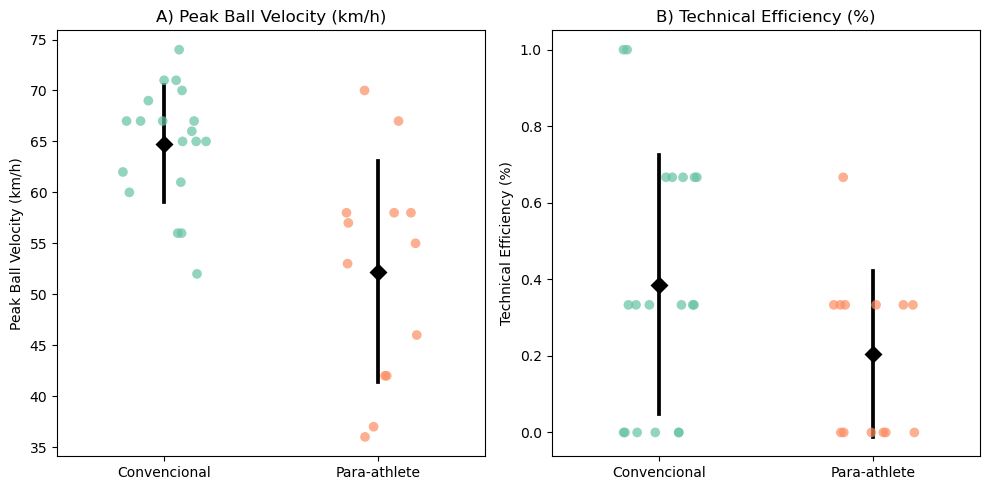

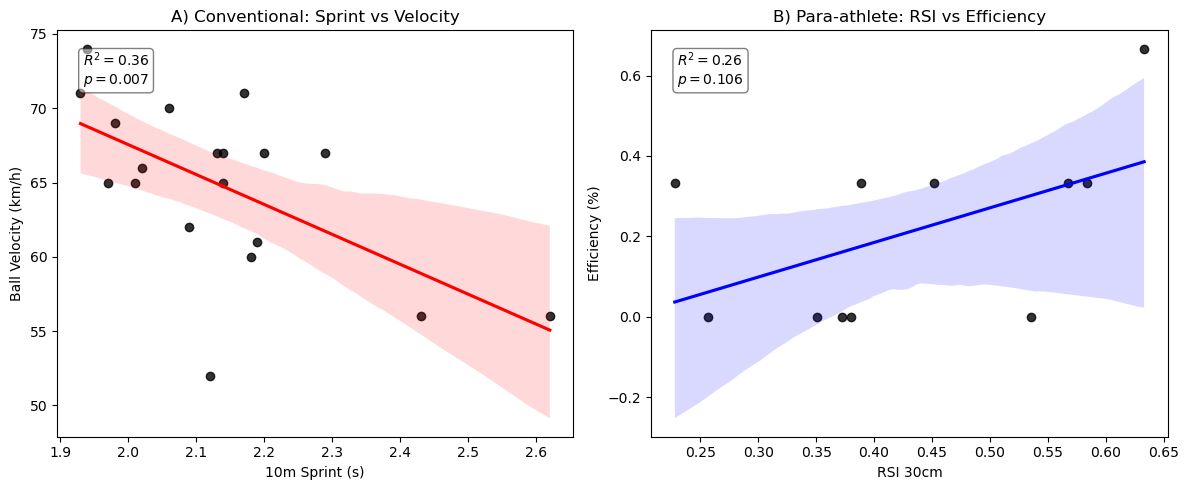

In [13]:
# =============================================================================
# BLOCK 6: PUBLICATION PLOTS (TIFF 600 DPI)
# =============================================================================

plt.rcParams.update({'font.size': 10, 'savefig.dpi': 600, 'savefig.format': 'tiff'})

# Function to annotate stats
def get_stats_ann(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    return f'$R^2 = {model.rsquared:.2f}$\n$p = {model.pvalues.iloc[1]:.3f}$'

# FIGURE 1: DISTRIBUTION
fig1, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_vars = [('Radar Vel Best', 'Peak Ball Velocity (km/h)'), 
             ('Target Efficiency', 'Technical Efficiency (%)')]

for i, (col, label) in enumerate(plot_vars):
    sns.stripplot(data=df_main, x='Group', y=col, hue='Group', palette="Set2", 
                  size=7, jitter=0.2, alpha=0.7, ax=axes[i], legend=False)
    sns.pointplot(data=df_main, x='Group', y=col, color='black', 
                  markers='D', errorbar='sd', ax=axes[i], linestyle='none')
    axes[i].set_title(f'{chr(65+i)}) {label}')
    axes[i].set_ylabel(label); axes[i].set_xlabel('')

plt.tight_layout()
plt.savefig('Figure1_Distribution.tiff', pil_kwargs={'compression': 'tiff_lzw'})

# FIGURE 2: REGRESSION (Based on significant findings)
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Filter
conv = df_main[df_main['Group'].str.contains('Conv', case=False)].dropna(subset=['Sprint 10m Best', 'Radar Vel Best'])
para = df_main[df_main['Group'].str.contains('Para', case=False)].dropna(subset=['Drop 30 RSI Best', 'Target Efficiency'])

# A) Conv: Sprint -> Velocity
sns.regplot(data=conv, x='Sprint 10m Best', y='Radar Vel Best', ax=ax1, color='black', line_kws={'color':'red'})
ax1.text(0.05, 0.95, get_stats_ann(conv['Sprint 10m Best'], conv['Radar Vel Best']), transform=ax1.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
ax1.set_title('A) Conventional: Sprint vs Velocity'); ax1.set_xlabel('10m Sprint (s)'); ax1.set_ylabel('Ball Velocity (km/h)')

# B) Para: RSI -> Efficiency
sns.regplot(data=para, x='Drop 30 RSI Best', y='Target Efficiency', ax=ax2, color='black', line_kws={'color':'blue'})
ax2.text(0.05, 0.95, get_stats_ann(para['Drop 30 RSI Best'], para['Target Efficiency']), transform=ax2.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
ax2.set_title('B) Para-athlete: RSI vs Efficiency'); ax2.set_xlabel('RSI 30cm'); ax2.set_ylabel('Efficiency (%)')

plt.tight_layout()
plt.savefig('Figure2_Regression.tiff', pil_kwargs={'compression': 'tiff_lzw'})
print("Figures Saved Successfully.")

In [24]:
# =============================================================================
# BLOCK 7: REPEATED MEASURES ANOVA (DROP JUMP HEIGHTS)
# =============================================================================
from statsmodels.stats.anova import AnovaRM

print("="*80)
print("REPEATED MEASURES ANOVA: RSI ACROSS HEIGHTS (15 vs 30 vs 45)")
print("="*80)

# 1. Prepare Data (Long Format)
rsi_cols = ['Drop 15 RSI Best', 'Drop 30 RSI Best', 'Drop 45 RSI Best']
# Create a copy with only needed columns
df_anova = df_main[['ID', 'Group'] + rsi_cols].dropna()

df_long = pd.melt(df_anova, id_vars=['ID', 'Group'], value_vars=rsi_cols, 
                  var_name='Height', value_name='RSI')

# 2. Run ANOVA for each Group
for group in ['Conventional', 'Para-athlete']: # Adjust names to match your CSV exactly
    print(f"\n>>> GROUP: {group.upper()}")
    # Filter by string match to be safe
    subset = df_long[df_long['Group'].str.contains(group[:4], case=False)]
    
    if len(subset) > 0:
        # Descriptive (Mean ± SD) to check against text
        print(subset.groupby('Height')['RSI'].agg(['mean', 'std']))
        
        # Run Repeated Measures ANOVA
        try:
            aov = AnovaRM(subset, 'RSI', 'ID', within=['Height']).fit()
            print(aov.summary())
        except Exception as e:
            print(f"Error running ANOVA: {e}")

REPEATED MEASURES ANOVA: RSI ACROSS HEIGHTS (15 vs 30 vs 45)

>>> GROUP: CONVENTIONAL
                  mean   std
Height                      
Drop 15 RSI Best 0.595 0.187
Drop 30 RSI Best 0.637 0.209
Drop 45 RSI Best 0.599 0.226
               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
Height  1.3625 2.0000 36.0000 0.2689


>>> GROUP: PARA-ATHLETE
                  mean   std
Height                      
Drop 15 RSI Best 0.387 0.135
Drop 30 RSI Best 0.432 0.134
Drop 45 RSI Best 0.374 0.161
               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
Height  1.7097 2.0000 20.0000 0.2063

